In [8]:
from control import *
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# kp, ki, kd
# 0.005493331705679495, 0.00024414807580797754, 30.81524926686217
# 3.9100684261974585, 18.57282502443793, 912.0234604105572
# 0.9775171065493646, 0.9775171065493646, 999.0224828934506
# 4.887585532746823, 275.65982404692085, 984.3597262952102
# 7.820136852394917, 85.04398826979472, 936.4613880742913
# 31.28054740957967, 44.965786901270775, 956.989247311828
# 8.79765395894428, 75.26881720430107, 947.2140762463343
kp = 31.28054740957967
ki = 44.965786901270775
kd = 947.2140762463343

In [10]:
plant = tf([1], [64,9.6,0.48,0.008])
pid = tf([kd,kp,ki], [1,0])

In [17]:
plantd = plant.sample(Ts=0.025, method='zoh', alpha=None)

In [19]:
plantd


4.065e-08 z^2 + 1.625e-07 z + 4.058e-08
---------------------------------------
  z^3 - 2.996 z^2 + 2.993 z - 0.9963

dt = 0.025

In [ ]:
sysd = feedback(pidd,plantd, sign=1)

In [60]:
sys = feedback(pid, plant, sign=1)

In [61]:
time = np.arange(0,90)

In [62]:
sys1 = feedback(pid*plant, 1)

<function matplotlib.pyplot.show>

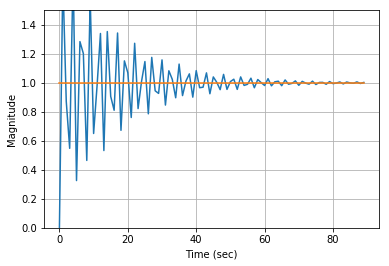

In [63]:
# PID compensated Step Response
t, s = step_response(sys1,T=time)
target = np.linspace(1, 1, num=len(t))
plt.figure()
plt.plot(t,s,t,target)
#plt.plot(t,s)
plt.ylim([0,1.5])
plt.ylabel(r'Magnitude')
plt.xlabel(r'Time (sec)')
plt.grid()
plt.show

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from control import *

In [ ]:
# Plant
num = [1]
den = [64,9.6,0.48,0.008]
G = tf(num, den)

# Plant Step Response
t, s = step_response(G)

#PID Controller
kp = 0.0361 
ki = 0.000731
kd = 0.6999

pid_num = [kd, kp, ki]
pid_den = [1, 0]
C = tf(pid_num,pid_den)

# System
T = feedback(C*G,1)

In [ ]:
# PID compensated Step Response
t, s = step_response(T)
target = np.linspace(1, 1, num=len(t))
plt.figure()
plt.plot(t,s,t,target)
#plt.plot(t,s)
plt.ylim([0,1.5])
plt.ylabel(r'Magnitude')
plt.xlabel(r'Time (sec)')
plt.grid()
plt.show

error = target - s

In [1]:
import matplotlib
import numpy
from control import *
import math

In [2]:
from deap import base, creator
# Crear clase FITNESS: ( Nombre de la clase, Delegando la clase como fitness, Posibles valores min y max del fitness )
creator.create("ControllerFitness", base.Fitness, weights=(1.0,))

# Crear clase CROMOSOMA: ( Nombre de la clase, type de los valores de la clase, Establecer fitness con la clase anterior )
creator.create("Controller", list, fitness=creator.ControllerFitness)

In [3]:
import random
from deap import tools

IND_SIZE = 30 # ki bits + kp bits + kd bits

# Functions to initialize populations from individuals

toolbox = base.Toolbox()

# Crear el ATRIBUTO de cromosomas ( Nombre del registro para el toolbox, Función para crear un cromosoma aleatorio )
toolbox.register("bit_attribute", random.randint, 0, 1) # random.choice, '10')

# Crear el CROMOSOMA ( Nombre del registro, , La clase cromosoma, La clase atributo, Tamaño de la población )
# Cuando se llame a toolbox.individual(), este llamará a tool.initRepeat()
toolbox.register("controller", tools.initRepeat, creator.Controller, toolbox.bit_attribute, n=IND_SIZE)

# Crear la POBLACIÓN ( Nombre del registro, , Type del cromosoma, El cromosoma )
toolbox.register("population", tools.initRepeat, list, toolbox.controller)

In [4]:
ind = toolbox.controller()

In [70]:
def evaluate(controller):
    controller = ''.join(map(str,controller))
    
    # PID controller
    _kp = int(controller[0:10],2)
    _ki = int(controller[10:20],2)
    _kd = int(controller[20:30],2)
    
    kp = 0 + _kp * ( (1000 - 0) / (math.pow(2,10) - 1) )
    ki = 0 + _ki * ( (1000 - 0) / (math.pow(2,10) - 1) )
    kd = 0 + _kd * ( (1000 - 0) / (math.pow(2,10) - 1) )
    
    # Plant
    num = [1]
    den = [64,9.6,0.48,0.008]
    plant = tf(num, den)
    
    pid_num = [kd, kp, ki]
    pid_den = [1, 0]
    pid = tf(pid_num,pid_den)

    # System
    sys = feedback(pid*plant,1)
    
    # PID compensated Step Response
    time = np.arange(0,900)
    t, s = step_response(sys,T=time)
    l = len(t)
    
    #total_error = sum(abs(1 - s))
    
    #total_error = sum(map(lambda x:abs(1-x)/l,s))
    
    total_error = 0
    while (1-s[l-total_error-1]) < 0.01:
        total_error = total_error + 1
    
    return (total_error),

In [71]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

In [72]:
ind = toolbox.controller()

In [73]:
def main():
    pop = toolbox.population(n=40)
    # pop[0:100] = prev
    CXPB, MUTPB, NGEN = 0.7, 0.1, 40

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    minFit = (1,)
    #while minFit > (0.02,):
    for g in range(NGEN):
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        minFit = min(fitnesses)
        print("=START=================================================================")
        print(fitnesses)
        print("=END===================================================================")
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring
    
    
    return pop

In [74]:
w = [1,2,3,4]
w[len(w)-1]

4

In [75]:
kx = main()

=START=================================================================
[(1,), (1,), (1,), (778,), (2,), (0,), (1,), (0,), (0,), (0,), (1,), (0,), (0,), (1,), (2,), (0,), (0,), (1,), (1,), (0,), (198,), (0,), (721,), (1,), (2,)]
=END===================================================================
=START=================================================================
[(0,), (821,), (1,), (0,), (799,), (1,), (818,), (0,), (198,), (198,), (0,), (823,), (218,), (2,), (809,), (769,), (284,), (198,), (0,), (0,), (721,), (1,), (2,), (823,), (0,), (1,), (0,), (198,), (284,)]
=END===================================================================
=START=================================================================
[(0,), (1,), (198,), (284,), (779,), (733,), (0,), (779,), (822,), (2,), (778,), (778,), (823,), (0,), (737,), (761,), (778,), (778,), (778,), (778,), (778,), (785,), (0,), (811,), (778,), (769,), (742,), (1,), (0,), (1,), (823,), (0,)]
=END=====================================

=START=================================================================
[(840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (838,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (825,), (0,), (840,), (840,), (797,), (840,), (840,), (840,), (840,)]
=END===================================================================
=START=================================================================
[(840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (837,), (840,), (840,), (840,), (840,), (840,), (840,)]
=END===================================================================
=START=================================================================
[(840,), (840,), (840,), (840,), (833,), (840,), (840,), (840,), (840,), (840,), (1,), (840,), (840,), (840,), (840,), (0,), (840,), (840,), (84

In [76]:
for bits in kx:
    controller = ''.join(map(str,bits))
    
    # PID controller
    _kp = int(controller[0:10],2)
    _ki = int(controller[10:20],2)
    _kd = int(controller[20:30],2)
    
    kp = 0 + _kp * ( (1000 - 0) / (pow(2,10) - 1) )
    ki = 0 + _ki * ( (1000 - 0) / (pow(2,10) - 1) )
    kd = 0 + _kd * ( (1000 - 0) / (pow(2,10) - 1) )
    
    print([_kp,_ki,_kd,kp,ki,kd])

[9, 77, 969, 8.79765395894428, 75.26881720430107, 947.2140762463343]
[9, 77, 969, 8.79765395894428, 75.26881720430107, 947.2140762463343]
[9, 9, 961, 8.79765395894428, 8.79765395894428, 939.3939393939394]
[9, 77, 969, 8.79765395894428, 75.26881720430107, 947.2140762463343]
[9, 77, 969, 8.79765395894428, 75.26881720430107, 947.2140762463343]
[9, 77, 969, 8.79765395894428, 75.26881720430107, 947.2140762463343]
[9, 77, 969, 8.79765395894428, 75.26881720430107, 947.2140762463343]
[9, 77, 969, 8.79765395894428, 75.26881720430107, 947.2140762463343]
[9, 77, 969, 8.79765395894428, 75.26881720430107, 947.2140762463343]
[9, 77, 969, 8.79765395894428, 75.26881720430107, 947.2140762463343]
[13, 77, 969, 12.70772238514174, 75.26881720430107, 947.2140762463343]
[9, 77, 969, 8.79765395894428, 75.26881720430107, 947.2140762463343]
[9, 77, 969, 8.79765395894428, 75.26881720430107, 947.2140762463343]
[41, 77, 969, 40.07820136852395, 75.26881720430107, 947.2140762463343]
[9, 77, 969, 8.79765395894428, 7

In [54]:
evaluate(kx[1])

(790,)

In [ ]:
controller = ''.join(map(str,kx[1]))
    
# PID controller
_kp = int(controller[0:10],2)
_ki = int(controller[10:20],2)
_kd = int(controller[20:30],2)

kp = 0 + _kp * ( (1000 - 0) / (pow(2,10) - 1) )
ki = 0 + _ki * ( (1000 - 0) / (pow(2,10) - 1) )
kd = 0 + _kd * ( (1000 - 0) / (pow(2,10) - 1) )
    
print([_kp,_ki,_kd,kp,ki,kd])

In [114]:
import pandas as pd
import numpy as np

In [132]:
x = pd.read_excel('antihorario.xlsx')
y = x['antihorapos']
x = x.drop('antihorapos', axis=1)

In [116]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4)

In [117]:
from sklearn.linear_model import Lasso
model = Lasso()

In [118]:
model.fit(x_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [119]:
predicted = model.predict(x_test)

In [120]:
predicted.shape

(2000,)

In [121]:
model.score(x_test,y_test)

0.9965451468889165

([array([159., 180., 191., 170., 191., 182., 214., 198., 216., 299.]),
  array([169., 177., 195., 159., 190., 174., 208., 172., 186., 370.])],
 array([-513.23      , -457.55102084, -401.87204167, -346.19306251,
        -290.51408335, -234.83510419, -179.15612502, -123.47714586,
         -67.7981667 ,  -12.11918753,   43.55979163]),
 <a list of 2 Lists of Patches objects>)

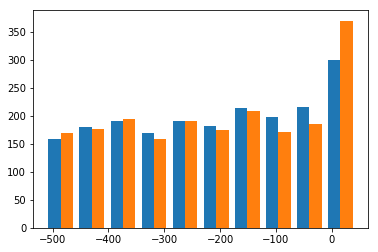

In [122]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([predicted, y_test])

In [169]:
def pidController(kp, ki, kd, dt, n, pid1, error0, error1, error2):
    q1 = kp + 0.5*dt*ki + (kd/dt)
    q2 = dt*ki*0.5 - kp - (2*kd/dt)
    q3 = kd/dt
    #error0 = np.random.random()
    pid0 = pid1 + q1 * error0 + q2 * error1 + q3 * error2
    
    pid1 = pid0
    error1 = error0
    error2 = error1
    
    d = {'pwm': [pid0], 'time': [dt * n]}
    
    
    return [d, pid1, error1, error2]

In [170]:
import matplotlib
import numpy
from control import *
import math
from deap import base, creator

In [171]:
# Crear clase FITNESS: ( Nombre de la clase, Delegando la clase como fitness, Posibles valores min y max del fitness )
creator.create("ControllerFitness", base.Fitness, weights=(-1.0,))

# Crear clase CROMOSOMA: ( Nombre de la clase, type de los valores de la clase, Establecer fitness con la clase anterior )
creator.create("Controller", list, fitness=creator.ControllerFitness)

/usr/local/lib/python3.5/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'ControllerFitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Controller' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [172]:
import random
from deap import tools

IND_SIZE = 30 # ki bits + kp bits + kd bits

# Functions to initialize populations from individuals

toolbox = base.Toolbox()

# Crear el ATRIBUTO de cromosomas ( Nombre del registro para el toolbox, Función para crear un cromosoma aleatorio )
toolbox.register("bit_attribute", random.randint, 0, 1) # random.choice, '10')

# Crear el CROMOSOMA ( Nombre del registro, , La clase cromosoma, La clase atributo, Tamaño de la población )
# Cuando se llame a toolbox.individual(), este llamará a tool.initRepeat()
toolbox.register("controller", tools.initRepeat, creator.Controller, toolbox.bit_attribute, n=IND_SIZE)

# Crear la POBLACIÓN ( Nombre del registro, , Type del cromosoma, El cromosoma )
toolbox.register("population", tools.initRepeat, list, toolbox.controller)

In [173]:
ind = toolbox.controller()

In [260]:
def evaluatePID(kp, ki, kd):
    error = 0
    
    pid1 = 0
    error0 = 0
    error1 = 0
    error2 = 0

    for k in np.arange(20):
    #while error < 9000000
        d, pid1, error1, error2  = pidController(kp, ki, kd, 0.025, k, pid1, error0, error1, error2)
        y = model.predict(pd.DataFrame(data=d))
        error0 = 1 - y
        error = error + error0
        if (error > 1000000):
            error = 1000000
        #print([d, pid1, error1, error2 ])
        print(d)
    
    return error

In [261]:
def evaluate(controller):
    controller = ''.join(map(str,controller))
    
    # PID controller
    _kp = int(controller[0:10],2)
    _ki = int(controller[10:20],2)
    _kd = int(controller[20:30],2)
    
    kp = 0 + _kp * ( (1000 - 0) / (math.pow(2,10) - 1) )
    ki = 0 + _ki * ( (1000 - 0) / (math.pow(2,10) - 1) )
    kd = 0 + _kd * ( (1000 - 0) / (math.pow(2,10) - 1) )
    
    total_error = evaluatePID(kp, ki, kd)
    
    return (total_error),

In [262]:
ind = toolbox.controller()

In [263]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

In [264]:
def main():
    pop = toolbox.population(n=40)
    # pop[0:100] = prev
    CXPB, MUTPB, NGEN = 0.7, 0.1, 40

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    minFit = (1,)
    #while minFit > (0.02,):
    for g in range(NGEN):
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        minFit = min(fitnesses)
        print("=START=================================================================")
        print(fitnesses)
        print("=END===================================================================")
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring
    
    
    return pop

In [ ]:
q = main()

{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-769996.73541545])]}
{'time': [0.05], 'pwm': [array([-3.18678658e+12])]}
{'time': [0.07500000000000001], 'pwm': [array([-1.31891549e+19])]}
{'time': [0.1], 'pwm': [array([-5.45859611e+25])]}
{'time': [0.125], 'pwm': [array([-2.2591494e+32])]}
{'time': [0.15000000000000002], 'pwm': [array([-9.34994255e+38])]}
{'time': [0.17500000000000002], 'pwm': [array([-3.86966111e+45])]}
{'time': [0.2], 'pwm': [array([-1.60153681e+52])]}
{'time': [0.225], 'pwm': [array([-6.62828104e+58])]}
{'time': [0.25], 'pwm': [array([-2.74324695e+65])]}
{'time': [0.275], 'pwm': [array([-1.13534773e+72])]}
{'time': [0.30000000000000004], 'pwm': [array([-4.69886412e+78])]}
{'time': [0.325], 'pwm': [array([-1.94471909e+85])]}
{'time': [0.35000000000000003], 'pwm': [array([-8.04860971e+91])]}
{'time': [0.375], 'pwm': [array([-3.33107843e+98])]}
{'time': [0.4], 'pwm': [array([-1.37863357e+105])]}
{'time': [0.42500000000000004], 'pwm': [array([-5.70575133e

{'time': [0.30000000000000004], 'pwm': [array([-4.80504372e+76])]}
{'time': [0.325], 'pwm': [array([-1.35738601e+83])]}
{'time': [0.35000000000000003], 'pwm': [array([-3.83450575e+89])]}
{'time': [0.375], 'pwm': [array([-1.08321688e+96])]}
{'time': [0.4], 'pwm': [array([-3.06000012e+102])]}
{'time': [0.42500000000000004], 'pwm': [array([-8.64425297e+108])]}
{'time': [0.45], 'pwm': [array([-2.44193159e+115])]}
{'time': [0.47500000000000003], 'pwm': [array([-6.89825933e+121])]}
{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-431825.38665645])]}
{'time': [0.05], 'pwm': [array([-1.00228593e+12])]}
{'time': [0.07500000000000001], 'pwm': [array([-2.32634924e+18])]}
{'time': [0.1], 'pwm': [array([-5.39955775e+24])]}
{'time': [0.125], 'pwm': [array([-1.25326084e+31])]}
{'time': [0.15000000000000002], 'pwm': [array([-2.9088729e+37])]}
{'time': [0.17500000000000002], 'pwm': [array([-6.7516205e+43])]}
{'time': [0.2], 'pwm': [array([-1.56708048e+50])]}
{'time': [0.225], 'pwm': [arr

{'time': [0.25], 'pwm': [array([-6.75288058e+65])]}
{'time': [0.275], 'pwm': [array([-3.05826756e+72])]}
{'time': [0.30000000000000004], 'pwm': [array([-1.38503863e+79])]}
{'time': [0.325], 'pwm': [array([-6.27261012e+85])]}
{'time': [0.35000000000000003], 'pwm': [array([-2.84076103e+92])]}
{'time': [0.375], 'pwm': [array([-1.28653353e+99])]}
{'time': [0.4], 'pwm': [array([-5.82649688e+105])]}
{'time': [0.42500000000000004], 'pwm': [array([-2.63872375e+112])]}
{'time': [0.45], 'pwm': [array([-1.1950342e+119])]}
{'time': [0.47500000000000003], 'pwm': [array([-5.41211159e+125])]}
{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-53393.7513465])]}
{'time': [0.05], 'pwm': [array([-1.53234835e+10])]}
{'time': [0.07500000000000001], 'pwm': [array([-4.3976743e+15])]}
{'time': [0.1], 'pwm': [array([-1.26208504e+21])]}
{'time': [0.125], 'pwm': [array([-3.62204778e+26])]}
{'time': [0.15000000000000002], 'pwm': [array([-1.0394886e+32])]}
{'time': [0.17500000000000002], 'pwm': [array

{'time': [0.375], 'pwm': [array([-1.53891851e+98])]}
{'time': [0.4], 'pwm': [array([-6.04953041e+104])]}
{'time': [0.42500000000000004], 'pwm': [array([-2.37808682e+111])]}
{'time': [0.45], 'pwm': [array([-9.3483238e+117])]}
{'time': [0.47500000000000003], 'pwm': [array([-3.67485145e+124])]}
{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-693266.45864111])]}
{'time': [0.05], 'pwm': [array([-2.5833045e+12])]}
{'time': [0.07500000000000001], 'pwm': [array([-9.6261117e+18])]}
{'time': [0.1], 'pwm': [array([-3.58695718e+25])]}
{'time': [0.125], 'pwm': [array([-1.3366001e+32])]}
{'time': [0.15000000000000002], 'pwm': [array([-4.98054403e+38])]}
{'time': [0.17500000000000002], 'pwm': [array([-1.85588935e+45])]}
{'time': [0.2], 'pwm': [array([-6.91556035e+51])]}
{'time': [0.225], 'pwm': [array([-2.57693029e+58])]}
{'time': [0.25], 'pwm': [array([-9.60235962e+64])]}
{'time': [0.275], 'pwm': [array([-3.5781065e+71])]}
{'time': [0.30000000000000004], 'pwm': [array([-1.33330209e+7

{'time': [0.17500000000000002], 'pwm': [array([-1.52992579e+40])]}
{'time': [0.2], 'pwm': [array([-1.07072212e+46])]}
{'time': [0.225], 'pwm': [array([-7.49347361e+51])]}
{'time': [0.25], 'pwm': [array([-5.2443249e+57])]}
{'time': [0.275], 'pwm': [array([-3.67025296e+63])]}
{'time': [0.30000000000000004], 'pwm': [array([-2.56863506e+69])]}
{'time': [0.325], 'pwm': [array([-1.79766521e+75])]}
{'time': [0.35000000000000003], 'pwm': [array([-1.25810017e+81])]}
{'time': [0.375], 'pwm': [array([-8.80484326e+86])]}
{'time': [0.4], 'pwm': [array([-6.16209e+92])]}
{'time': [0.42500000000000004], 'pwm': [array([-4.31255299e+98])]}
{'time': [0.45], 'pwm': [array([-3.01815023e+104])]}
{'time': [0.47500000000000003], 'pwm': [array([-2.11225944e+110])]}
{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-611145.80903305])]}
{'time': [0.05], 'pwm': [array([-2.00754327e+12])]}
{'time': [0.07500000000000001], 'pwm': [array([-6.59454536e+18])]}
{'time': [0.1], 'pwm': [array([-2.16623119e+25

{'time': [0.42500000000000004], 'pwm': [array([-4.57286417e+110])]}
{'time': [0.45], 'pwm': [array([-1.63145229e+117])]}
{'time': [0.47500000000000003], 'pwm': [array([-5.82050214e+123])]}
{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-721566.25455836])]}
{'time': [0.05], 'pwm': [array([-2.79851506e+12])]}
{'time': [0.07500000000000001], 'pwm': [array([-1.08537289e+19])]}
{'time': [0.1], 'pwm': [array([-4.20949783e+25])]}
{'time': [0.125], 'pwm': [array([-1.63260684e+32])]}
{'time': [0.15000000000000002], 'pwm': [array([-6.33188375e+38])]}
{'time': [0.17500000000000002], 'pwm': [array([-2.45575057e+45])]}
{'time': [0.2], 'pwm': [array([-9.52435502e+51])]}
{'time': [0.225], 'pwm': [array([-3.69391499e+58])]}
{'time': [0.25], 'pwm': [array([-1.43264378e+65])]}
{'time': [0.275], 'pwm': [array([-5.55634929e+71])]}
{'time': [0.30000000000000004], 'pwm': [array([-2.15496817e+78])]}
{'time': [0.325], 'pwm': [array([-8.35780399e+84])]}
{'time': [0.35000000000000003], 'pwm': [a

{'time': [0.375], 'pwm': [array([-6.89849646e+97])]}
{'time': [0.4], 'pwm': [array([-2.57057181e+104])]}
{'time': [0.42500000000000004], 'pwm': [array([-9.57866615e+110])]}
{'time': [0.45], 'pwm': [array([-3.56927765e+117])]}
{'time': [0.47500000000000003], 'pwm': [array([-1.33001221e+124])]}
{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-735029.05128204])]}
{'time': [0.05], 'pwm': [array([-2.90391718e+12])]}
{'time': [0.07500000000000001], 'pwm': [array([-1.14726524e+19])]}
{'time': [0.1], 'pwm': [array([-4.53255882e+25])]}
{'time': [0.125], 'pwm': [array([-1.79070093e+32])]}
{'time': [0.15000000000000002], 'pwm': [array([-7.07461273e+38])]}
{'time': [0.17500000000000002], 'pwm': [array([-2.79500303e+45])]}
{'time': [0.2], 'pwm': [array([-1.10423598e+52])]}
{'time': [0.225], 'pwm': [array([-4.36256093e+58])]}
{'time': [0.25], 'pwm': [array([-1.72353901e+65])]}
{'time': [0.275], 'pwm': [array([-6.80927271e+71])]}
{'time': [0.30000000000000004], 'pwm': [array([-2.690173

{'time': [0.25], 'pwm': [array([-9.16684478e+63])]}
{'time': [0.275], 'pwm': [array([-2.70071876e+70])]}
{'time': [0.30000000000000004], 'pwm': [array([-7.95680738e+76])]}
{'time': [0.325], 'pwm': [array([-2.34421979e+83])]}
{'time': [0.35000000000000003], 'pwm': [array([-6.90649676e+89])]}
{'time': [0.375], 'pwm': [array([-2.03477923e+96])]}
{'time': [0.4], 'pwm': [array([-5.99482873e+102])]}
{'time': [0.42500000000000004], 'pwm': [array([-1.76618529e+109])]}
{'time': [0.45], 'pwm': [array([-5.20350225e+115])]}
{'time': [0.47500000000000003], 'pwm': [array([-1.53304616e+122])]}
{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-735029.05128204])]}
{'time': [0.05], 'pwm': [array([-2.90391718e+12])]}
{'time': [0.07500000000000001], 'pwm': [array([-1.14726524e+19])]}
{'time': [0.1], 'pwm': [array([-4.53255882e+25])]}
{'time': [0.125], 'pwm': [array([-1.79070093e+32])]}
{'time': [0.15000000000000002], 'pwm': [array([-7.07461273e+38])]}
{'time': [0.17500000000000002], 'pwm': [

{'time': [0.45], 'pwm': [array([-1.27255379e+119])]}
{'time': [0.47500000000000003], 'pwm': [array([-5.78334355e+125])]}
{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-729915.73976616])]}
{'time': [0.05], 'pwm': [array([-2.86365487e+12])]}
{'time': [0.07500000000000001], 'pwm': [array([-1.12348819e+19])]}
{'time': [0.1], 'pwm': [array([-4.40774383e+25])]}
{'time': [0.125], 'pwm': [array([-1.72927547e+32])]}
{'time': [0.15000000000000002], 'pwm': [array([-6.78440894e+38])]}
{'time': [0.17500000000000002], 'pwm': [array([-2.66170459e+45])]}
{'time': [0.2], 'pwm': [array([-1.04425771e+52])]}
{'time': [0.225], 'pwm': [array([-4.09690152e+58])]}
{'time': [0.25], 'pwm': [array([-1.60732375e+65])]}
{'time': [0.275], 'pwm': [array([-6.30595978e+71])]}
{'time': [0.30000000000000004], 'pwm': [array([-2.47399622e+78])]}
{'time': [0.325], 'pwm': [array([-9.70614707e+84])]}
{'time': [0.35000000000000003], 'pwm': [array([-3.80798039e+91])]}
{'time': [0.375], 'pwm': [array([-1.493972

{'time': [0.275], 'pwm': [array([-3.04251942e+71])]}
{'time': [0.30000000000000004], 'pwm': [array([-1.11713805e+78])]}
{'time': [0.325], 'pwm': [array([-4.10185525e+84])]}
{'time': [0.35000000000000003], 'pwm': [array([-1.50610003e+91])]}
{'time': [0.375], 'pwm': [array([-5.53002765e+97])]}
{'time': [0.4], 'pwm': [array([-2.03048969e+104])]}
{'time': [0.42500000000000004], 'pwm': [array([-7.45545709e+110])]}
{'time': [0.45], 'pwm': [array([-2.73745987e+117])]}
{'time': [0.47500000000000003], 'pwm': [array([-1.00512771e+124])]}
{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-884929.24502204])]}
{'time': [0.05], 'pwm': [array([-4.20912956e+12])]}
{'time': [0.07500000000000001], 'pwm': [array([-2.00205474e+19])]}
{'time': [0.1], 'pwm': [array([-9.52268905e+25])]}
{'time': [0.125], 'pwm': [array([-4.52942693e+32])]}
{'time': [0.15000000000000002], 'pwm': [array([-2.15440284e+39])]}
{'time': [0.17500000000000002], 'pwm': [array([-1.02473263e+46])]}
{'time': [0.2], 'pwm': [a

{'time': [0.15000000000000002], 'pwm': [array([-8.58290911e+38])]}
{'time': [0.17500000000000002], 'pwm': [array([-3.50189214e+45])]}
{'time': [0.2], 'pwm': [array([-1.42879861e+52])]}
{'time': [0.225], 'pwm': [array([-5.8296069e+58])]}
{'time': [0.25], 'pwm': [array([-2.37852392e+65])]}
{'time': [0.275], 'pwm': [array([-9.70455834e+71])]}
{'time': [0.30000000000000004], 'pwm': [array([-3.95953355e+78])]}
{'time': [0.325], 'pwm': [array([-1.61551978e+85])]}
{'time': [0.35000000000000003], 'pwm': [array([-6.59144348e+91])]}
{'time': [0.375], 'pwm': [array([-2.68935903e+98])]}
{'time': [0.4], 'pwm': [array([-1.09727892e+105])]}
{'time': [0.42500000000000004], 'pwm': [array([-4.47698139e+111])]}
{'time': [0.45], 'pwm': [array([-1.82664243e+118])]}
{'time': [0.47500000000000003], 'pwm': [array([-7.45283994e+124])]}
{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-734940.75999209])]}
{'time': [0.05], 'pwm': [array([-2.90321959e+12])]}
{'time': [0.07500000000000001], 'pwm': [a

{'time': [0.25], 'pwm': [array([-1.24917829e+66])]}
{'time': [0.275], 'pwm': [array([-6.01622918e+72])]}
{'time': [0.30000000000000004], 'pwm': [array([-2.89750581e+79])]}
{'time': [0.325], 'pwm': [array([-1.39548207e+86])]}
{'time': [0.35000000000000003], 'pwm': [array([-6.72085003e+92])]}
{'time': [0.375], 'pwm': [array([-3.23686174e+99])]}
{'time': [0.4], 'pwm': [array([-1.55892095e+106])]}
{'time': [0.42500000000000004], 'pwm': [array([-7.50799609e+112])]}
{'time': [0.45], 'pwm': [array([-3.61596304e+119])]}
{'time': [0.47500000000000003], 'pwm': [array([-1.7415018e+126])]}
=START=================================================================
[(array([-4.82344166e+126]),), (array([-6.89001356e+127]),), (array([-4.21672212e+126]),), (array([-5.90711049e+126]),), (array([-7.74093492e+126]),), (array([-6.17980555e+127]),), (array([-6.09636022e+126]),), (array([-9.31242972e+126]),), (array([-4.66673238e+127]),), (array([-6.1839677e+127]),), (array([-5.94500426e+127]),), (array([-1.19

{'time': [0.325], 'pwm': [array([-1.13242955e+86])]}
{'time': [0.35000000000000003], 'pwm': [array([-5.36701994e+92])]}
{'time': [0.375], 'pwm': [array([-2.54363753e+99])]}
{'time': [0.4], 'pwm': [array([-1.20552783e+106])]}
{'time': [0.42500000000000004], 'pwm': [array([-5.71346086e+112])]}
{'time': [0.45], 'pwm': [array([-2.70782923e+119])]}
{'time': [0.47500000000000003], 'pwm': [array([-1.2833446e+126])]}
{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-846466.20080261])]}
{'time': [0.05], 'pwm': [array([-3.85118557e+12])]}
{'time': [0.07500000000000001], 'pwm': [array([-1.75218184e+19])]}
{'time': [0.1], 'pwm': [array([-7.97193781e+25])]}
{'time': [0.125], 'pwm': [array([-3.62700898e+32])]}
{'time': [0.15000000000000002], 'pwm': [array([-1.65018775e+39])]}
{'time': [0.17500000000000002], 'pwm': [array([-7.50789322e+45])]}
{'time': [0.2], 'pwm': [array([-3.41588165e+52])]}
{'time': [0.225], 'pwm': [array([-1.55413072e+59])]}
{'time': [0.25], 'pwm': [array([-7.0708605

{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-882300.00624046])]}
{'time': [0.05], 'pwm': [array([-4.18415499e+12])]}
{'time': [0.07500000000000001], 'pwm': [array([-1.98426263e+19])]}
{'time': [0.1], 'pwm': [array([-9.41001989e+25])]}
{'time': [0.125], 'pwm': [array([-4.46253803e+32])]}
{'time': [0.15000000000000002], 'pwm': [array([-2.11628094e+39])]}
{'time': [0.17500000000000002], 'pwm': [array([-1.00360937e+46])]}
{'time': [0.2], 'pwm': [array([-4.75944265e+52])]}
{'time': [0.225], 'pwm': [array([-2.25708278e+59])]}
{'time': [0.25], 'pwm': [array([-1.0703822e+66])]}
{'time': [0.275], 'pwm': [array([-5.07610113e+72])]}
{'time': [0.30000000000000004], 'pwm': [array([-2.40725255e+79])]}
{'time': [0.325], 'pwm': [array([-1.14159759e+86])]}
{'time': [0.35000000000000003], 'pwm': [array([-5.41382774e+92])]}
{'time': [0.375], 'pwm': [array([-2.56741351e+99])]}
{'time': [0.4], 'pwm': [array([-1.21755114e+106])]}
{'time': [0.42500000000000004], 'pwm': [array([-5.77402421e

{'time': [0.47500000000000003], 'pwm': [array([-1.29565292e+126])]}
{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-837870.52914525])]}
{'time': [0.05], 'pwm': [array([-3.77336688e+12])]}
{'time': [0.07500000000000001], 'pwm': [array([-1.69934303e+19])]}
{'time': [0.1], 'pwm': [array([-7.65302403e+25])]}
{'time': [0.125], 'pwm': [array([-3.44655409e+32])]}
{'time': [0.15000000000000002], 'pwm': [array([-1.55216227e+39])]}
{'time': [0.17500000000000002], 'pwm': [array([-6.99019262e+45])]}
{'time': [0.2], 'pwm': [array([-3.14804669e+52])]}
{'time': [0.225], 'pwm': [array([-1.41772888e+59])]}
{'time': [0.25], 'pwm': [array([-6.38476929e+65])]}
{'time': [0.275], 'pwm': [array([-2.87539313e+72])]}
{'time': [0.30000000000000004], 'pwm': [array([-1.29493883e+79])]}
{'time': [0.325], 'pwm': [array([-5.83178191e+85])]}
{'time': [0.35000000000000003], 'pwm': [array([-2.6263542e+92])]}
{'time': [0.375], 'pwm': [array([-1.18278367e+99])]}
{'time': [0.4], 'pwm': [array([-5.32668899e

{'time': [0.1], 'pwm': [array([-9.52264242e+25])]}
{'time': [0.125], 'pwm': [array([-4.52939921e+32])]}
{'time': [0.15000000000000002], 'pwm': [array([-2.15438701e+39])]}
{'time': [0.17500000000000002], 'pwm': [array([-1.02472385e+46])]}
{'time': [0.2], 'pwm': [array([-4.87404987e+52])]}
{'time': [0.225], 'pwm': [array([-2.31831845e+59])]}
{'time': [0.25], 'pwm': [array([-1.10269706e+66])]}
{'time': [0.275], 'pwm': [array([-5.24492567e+72])]}
{'time': [0.30000000000000004], 'pwm': [array([-2.49472375e+79])]}
{'time': [0.325], 'pwm': [array([-1.18660339e+86])]}
{'time': [0.35000000000000003], 'pwm': [array([-5.64402212e+92])]}
{'time': [0.375], 'pwm': [array([-2.68455206e+99])]}
{'time': [0.4], 'pwm': [array([-1.27689431e+106])]}
{'time': [0.42500000000000004], 'pwm': [array([-6.07348658e+112])]}
{'time': [0.45], 'pwm': [array([-2.88882477e+119])]}
{'time': [0.47500000000000003], 'pwm': [array([-1.37405565e+126])]}
{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-877100.0

{'time': [0.35000000000000003], 'pwm': [array([-5.40190463e+92])]}
{'time': [0.375], 'pwm': [array([-2.56135578e+99])]}
{'time': [0.4], 'pwm': [array([-1.21448709e+106])]}
{'time': [0.42500000000000004], 'pwm': [array([-5.75858654e+112])]}
{'time': [0.45], 'pwm': [array([-2.73047932e+119])]}
{'time': [0.47500000000000003], 'pwm': [array([-1.29467835e+126])]}
{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-896804.15268758])]}
{'time': [0.05], 'pwm': [array([-4.32285251e+12])]}
{'time': [0.07500000000000001], 'pwm': [array([-2.08373811e+19])]}
{'time': [0.1], 'pwm': [array([-1.00442116e+26])]}
{'time': [0.125], 'pwm': [array([-4.84159626e+32])]}
{'time': [0.15000000000000002], 'pwm': [array([-2.33378739e+39])]}
{'time': [0.17500000000000002], 'pwm': [array([-1.12495203e+46])]}
{'time': [0.2], 'pwm': [array([-5.42258943e+52])]}
{'time': [0.225], 'pwm': [array([-2.61384265e+59])]}
{'time': [0.25], 'pwm': [array([-1.25994666e+66])]}
{'time': [0.275], 'pwm': [array([-6.073301

{'time': [0.1], 'pwm': [array([-1.00398686e+26])]}
{'time': [0.125], 'pwm': [array([-4.83897958e+32])]}
{'time': [0.15000000000000002], 'pwm': [array([-2.33227389e+39])]}
{'time': [0.17500000000000002], 'pwm': [array([-1.12410094e+46])]}
{'time': [0.2], 'pwm': [array([-5.4179011e+52])]}
{'time': [0.225], 'pwm': [array([-2.61130039e+59])]}
{'time': [0.25], 'pwm': [array([-1.25858513e+66])]}
{'time': [0.275], 'pwm': [array([-6.06608312e+72])]}
{'time': [0.30000000000000004], 'pwm': [array([-2.92370882e+79])]}
{'time': [0.325], 'pwm': [array([-1.40915861e+86])]}
{'time': [0.35000000000000003], 'pwm': [array([-6.79181175e+92])]}
{'time': [0.375], 'pwm': [array([-3.27349289e+99])]}
{'time': [0.4], 'pwm': [array([-1.57774627e+106])]}
{'time': [0.42500000000000004], 'pwm': [array([-7.60436447e+112])]}
{'time': [0.45], 'pwm': [array([-3.66512411e+119])]}
{'time': [0.47500000000000003], 'pwm': [array([-1.76650327e+126])]}
{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-896748.36

{'time': [0.05], 'pwm': [array([-4.33453668e+12])]}
{'time': [0.07500000000000001], 'pwm': [array([-2.09219198e+19])]}
{'time': [0.1], 'pwm': [array([-1.00985817e+26])]}
{'time': [0.125], 'pwm': [array([-4.8743783e+32])]}
{'time': [0.15000000000000002], 'pwm': [array([-2.35276246e+39])]}
{'time': [0.17500000000000002], 'pwm': [array([-1.1356302e+46])]}
{'time': [0.2], 'pwm': [array([-5.4814541e+52])]}
{'time': [0.225], 'pwm': [array([-2.6457855e+59])]}
{'time': [0.25], 'pwm': [array([-1.27706641e+66])]}
{'time': [0.275], 'pwm': [array([-6.16413769e+72])]}
{'time': [0.30000000000000004], 'pwm': [array([-2.97530287e+79])]}
{'time': [0.325], 'pwm': [array([-1.43611769e+86])]}
{'time': [0.35000000000000003], 'pwm': [array([-6.93184559e+92])]}
{'time': [0.375], 'pwm': [array([-3.34585973e+99])]}
{'time': [0.4], 'pwm': [array([-1.61497789e+106])]}
{'time': [0.42500000000000004], 'pwm': [array([-7.7951671e+112])]}
{'time': [0.45], 'pwm': [array([-3.76256732e+119])]}
{'time': [0.47500000000000

{'time': [0.275], 'pwm': [array([-5.11655989e+72])]}
{'time': [0.30000000000000004], 'pwm': [array([-2.42819123e+79])]}
{'time': [0.325], 'pwm': [array([-1.15235877e+86])]}
{'time': [0.35000000000000003], 'pwm': [array([-5.46880625e+92])]}
{'time': [0.375], 'pwm': [array([-2.59535854e+99])]}
{'time': [0.4], 'pwm': [array([-1.23169219e+106])]}
{'time': [0.42500000000000004], 'pwm': [array([-5.84530279e+112])]}
{'time': [0.45], 'pwm': [array([-2.77403437e+119])]}
{'time': [0.47500000000000003], 'pwm': [array([-1.31648727e+126])]}
{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-884874.53692213])]}
{'time': [0.05], 'pwm': [array([-4.20860914e+12])]}
{'time': [0.07500000000000001], 'pwm': [array([-2.00168345e+19])]}
{'time': [0.1], 'pwm': [array([-9.52033442e+25])]}
{'time': [0.125], 'pwm': [array([-4.52802701e+32])]}
{'time': [0.15000000000000002], 'pwm': [array([-2.15360383e+39])]}
{'time': [0.17500000000000002], 'pwm': [array([-1.02428926e+46])]}
{'time': [0.2], 'pwm': [a

{'time': [0.42500000000000004], 'pwm': [array([-8.94466919e+112])]}
{'time': [0.45], 'pwm': [array([-4.352484e+119])]}
{'time': [0.47500000000000003], 'pwm': [array([-2.11792259e+126])]}
{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-902295.00425925])]}
{'time': [0.05], 'pwm': [array([-4.37594951e+12])]}
{'time': [0.07500000000000001], 'pwm': [array([-2.12224716e+19])]}
{'time': [0.1], 'pwm': [array([-1.02924703e+26])]}
{'time': [0.125], 'pwm': [array([-4.99164029e+32])]}
{'time': [0.15000000000000002], 'pwm': [array([-2.42084476e+39])]}
{'time': [0.17500000000000002], 'pwm': [array([-1.17406083e+46])]}
{'time': [0.2], 'pwm': [array([-5.69395801e+52])]}
{'time': [0.225], 'pwm': [array([-2.76145468e+59])]}
{'time': [0.25], 'pwm': [array([-1.33924977e+66])]}
{'time': [0.275], 'pwm': [array([-6.49509099e+72])]}
{'time': [0.30000000000000004], 'pwm': [array([-3.149988e+79])]}
{'time': [0.325], 'pwm': [array([-1.52768058e+86])]}
{'time': [0.35000000000000003], 'pwm': [array

{'time': [0.25], 'pwm': [array([-1.29365471e+66])]}
{'time': [0.275], 'pwm': [array([-6.25226981e+72])]}
{'time': [0.30000000000000004], 'pwm': [array([-3.0217397e+79])]}
{'time': [0.325], 'pwm': [array([-1.46041535e+86])]}
{'time': [0.35000000000000003], 'pwm': [array([-7.05822873e+92])]}
{'time': [0.375], 'pwm': [array([-3.41126193e+99])]}
{'time': [0.4], 'pwm': [array([-1.64867255e+106])]}
{'time': [0.42500000000000004], 'pwm': [array([-7.96808109e+112])]}
{'time': [0.45], 'pwm': [array([-3.85099615e+119])]}
{'time': [0.47500000000000003], 'pwm': [array([-1.86119734e+126])]}
{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-882674.83797447])]}
{'time': [0.05], 'pwm': [array([-4.18771089e+12])]}
{'time': [0.07500000000000001], 'pwm': [array([-1.98679265e+19])]}
{'time': [0.1], 'pwm': [array([-9.4260209e+25])]}
{'time': [0.125], 'pwm': [array([-4.4720253e+32])]}
{'time': [0.15000000000000002], 'pwm': [array([-2.12168109e+39])]}
{'time': [0.17500000000000002], 'pwm': [arr

{'time': [0.17500000000000002], 'pwm': [array([-1.17456416e+46])]}
{'time': [0.2], 'pwm': [array([-5.69674785e+52])]}
{'time': [0.225], 'pwm': [array([-2.76297687e+59])]}
{'time': [0.25], 'pwm': [array([-1.34007005e+66])]}
{'time': [0.275], 'pwm': [array([-6.49946714e+72])]}
{'time': [0.30000000000000004], 'pwm': [array([-3.15230336e+79])]}
{'time': [0.325], 'pwm': [array([-1.5288971e+86])]}
{'time': [0.35000000000000003], 'pwm': [array([-7.41529628e+92])]}
{'time': [0.375], 'pwm': [array([-3.59648919e+99])]}
{'time': [0.4], 'pwm': [array([-1.74433145e+106])]}
{'time': [0.42500000000000004], 'pwm': [array([-8.46017338e+112])]}
{'time': [0.45], 'pwm': [array([-4.10326452e+119])]}
{'time': [0.47500000000000003], 'pwm': [array([-1.9901223e+126])]}
=START=================================================================
[(array([-2.32807381e+128]),), (array([-1.95915511e+128]),), (array([-2.21668642e+128]),), (array([-2.52319701e+128]),), (array([-2.36818483e+128]),), (array([-2.21734618e+1

{'time': [0.45], 'pwm': [array([-4.34943813e+119])]}
{'time': [0.47500000000000003], 'pwm': [array([-2.11635816e+126])]}
{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-905296.90811741])]}
{'time': [0.05], 'pwm': [array([-4.4051152e+12])]}
{'time': [0.07500000000000001], 'pwm': [array([-2.14349964e+19])]}
{'time': [0.1], 'pwm': [array([-1.04301261e+26])]}
{'time': [0.125], 'pwm': [array([-5.0752297e+32])]}
{'time': [0.15000000000000002], 'pwm': [array([-2.46957288e+39])]}
{'time': [0.17500000000000002], 'pwm': [array([-1.20167767e+46])]}
{'time': [0.2], 'pwm': [array([-5.84728328e+52])]}
{'time': [0.225], 'pwm': [array([-2.84524899e+59])]}
{'time': [0.25], 'pwm': [array([-1.38447916e+66])]}
{'time': [0.275], 'pwm': [array([-6.73678312e+72])]}
{'time': [0.30000000000000004], 'pwm': [array([-3.27807368e+79])]}
{'time': [0.325], 'pwm': [array([-1.59508876e+86])]}
{'time': [0.35000000000000003], 'pwm': [array([-7.76159537e+92])]}
{'time': [0.375], 'pwm': [array([-3.77674047

{'time': [0.05], 'pwm': [array([-4.40512047e+12])]}
{'time': [0.07500000000000001], 'pwm': [array([-2.14350348e+19])]}
{'time': [0.1], 'pwm': [array([-1.0430151e+26])]}
{'time': [0.125], 'pwm': [array([-5.07524488e+32])]}
{'time': [0.15000000000000002], 'pwm': [array([-2.46958174e+39])]}
{'time': [0.17500000000000002], 'pwm': [array([-1.2016827e+46])]}
{'time': [0.2], 'pwm': [array([-5.84731127e+52])]}
{'time': [0.225], 'pwm': [array([-2.84526431e+59])]}
{'time': [0.25], 'pwm': [array([-1.38448744e+66])]}
{'time': [0.275], 'pwm': [array([-6.73682746e+72])]}
{'time': [0.30000000000000004], 'pwm': [array([-3.27809721e+79])]}
{'time': [0.325], 'pwm': [array([-1.59510117e+86])]}
{'time': [0.35000000000000003], 'pwm': [array([-7.76166039e+92])]}
{'time': [0.375], 'pwm': [array([-3.77677437e+99])]}
{'time': [0.4], 'pwm': [array([-1.83775428e+106])]}
{'time': [0.42500000000000004], 'pwm': [array([-8.94239496e+112])]}
{'time': [0.45], 'pwm': [array([-4.35131227e+119])]}
{'time': [0.47500000000

{'time': [0.42500000000000004], 'pwm': [array([-8.94230401e+112])]}
{'time': [0.45], 'pwm': [array([-4.35126541e+119])]}
{'time': [0.47500000000000003], 'pwm': [array([-2.11729669e+126])]}
{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-905296.90811741])]}
{'time': [0.05], 'pwm': [array([-4.4051152e+12])]}
{'time': [0.07500000000000001], 'pwm': [array([-2.14349964e+19])]}
{'time': [0.1], 'pwm': [array([-1.04301261e+26])]}
{'time': [0.125], 'pwm': [array([-5.0752297e+32])]}
{'time': [0.15000000000000002], 'pwm': [array([-2.46957288e+39])]}
{'time': [0.17500000000000002], 'pwm': [array([-1.20167767e+46])]}
{'time': [0.2], 'pwm': [array([-5.84728328e+52])]}
{'time': [0.225], 'pwm': [array([-2.84524899e+59])]}
{'time': [0.25], 'pwm': [array([-1.38447916e+66])]}
{'time': [0.275], 'pwm': [array([-6.73678312e+72])]}
{'time': [0.30000000000000004], 'pwm': [array([-3.27807368e+79])]}
{'time': [0.325], 'pwm': [array([-1.59508876e+86])]}
{'time': [0.35000000000000003], 'pwm': [arr

{'time': [0.025], 'pwm': [array([-905275.78320754])]}
{'time': [0.05], 'pwm': [array([-4.40490962e+12])]}
{'time': [0.07500000000000001], 'pwm': [array([-2.14334959e+19])]}
{'time': [0.1], 'pwm': [array([-1.04291526e+26])]}
{'time': [0.125], 'pwm': [array([-5.07463758e+32])]}
{'time': [0.15000000000000002], 'pwm': [array([-2.46922713e+39])]}
{'time': [0.17500000000000002], 'pwm': [array([-1.2014814e+46])]}
{'time': [0.2], 'pwm': [array([-5.84619181e+52])]}
{'time': [0.225], 'pwm': [array([-2.84465151e+59])]}
{'time': [0.25], 'pwm': [array([-1.38415613e+66])]}
{'time': [0.275], 'pwm': [array([-6.73505411e+72])]}
{'time': [0.30000000000000004], 'pwm': [array([-3.27715588e+79])]}
{'time': [0.325], 'pwm': [array([-1.59460495e+86])]}
{'time': [0.35000000000000003], 'pwm': [array([-7.75906014e+92])]}
{'time': [0.375], 'pwm': [array([-3.77541875e+99])]}
{'time': [0.4], 'pwm': [array([-1.83705068e+106])]}
{'time': [0.42500000000000004], 'pwm': [array([-8.93875733e+112])]}
{'time': [0.45], 'pwm

{'time': [0.45], 'pwm': [array([-4.48320927e+119])]}
{'time': [0.47500000000000003], 'pwm': [array([-2.18512307e+126])]}
{'time': [0.0], 'pwm': [0.0]}
{'time': [0.025], 'pwm': [array([-905067.78409503])]}
{'time': [0.05], 'pwm': [array([-4.40288568e+12])]}
{'time': [0.07500000000000001], 'pwm': [array([-2.14187254e+19])]}
{'time': [0.1], 'pwm': [array([-1.04195709e+26])]}
{'time': [0.125], 'pwm': [array([-5.06881043e+32])]}
{'time': [0.15000000000000002], 'pwm': [array([-2.46582506e+39])]}
{'time': [0.17500000000000002], 'pwm': [array([-1.19955033e+46])]}
{'time': [0.2], 'pwm': [array([-5.83545452e+52])]}
{'time': [0.225], 'pwm': [array([-2.83877454e+59])]}
{'time': [0.25], 'pwm': [array([-1.38097913e+66])]}
{'time': [0.275], 'pwm': [array([-6.7180515e+72])]}
{'time': [0.30000000000000004], 'pwm': [array([-3.26813164e+79])]}
{'time': [0.325], 'pwm': [array([-1.58984855e+86])]}
{'time': [0.35000000000000003], 'pwm': [array([-7.73413892e+92])]}
{'time': [0.375], 'pwm': [array([-3.7624278

In [219]:
for bits in q:
    controller = ''.join(map(str,bits))
    
    # PID controller
    _kp = int(controller[0:10],2)
    _ki = int(controller[10:20],2)
    _kd = int(controller[20:30],2)
    
    kp = 0 + _kp * ( (1000 - 0) / (pow(2,10) - 1) )
    ki = 0 + _ki * ( (1000 - 0) / (pow(2,10) - 1) )
    kd = 0 + _kd * ( (1000 - 0) / (pow(2,10) - 1) )
    
    print([_kp,_ki,_kd,kp,ki,kd])

[1023, 925, 1021, 1000.0, 904.2033235581623, 998.0449657869013]
[1023, 927, 1023, 1000.0, 906.158357771261, 1000.0]
[1023, 927, 1021, 1000.0, 906.158357771261, 998.0449657869013]
[1023, 927, 1021, 1000.0, 906.158357771261, 998.0449657869013]
[1023, 925, 1023, 1000.0, 904.2033235581623, 1000.0]
[1023, 927, 1021, 1000.0, 906.158357771261, 998.0449657869013]
[1023, 927, 1021, 1000.0, 906.158357771261, 998.0449657869013]
[1023, 927, 1020, 1000.0, 906.158357771261, 997.067448680352]
[1023, 927, 1023, 1000.0, 906.158357771261, 1000.0]
[1023, 927, 1023, 1000.0, 906.158357771261, 1000.0]
[1023, 925, 1021, 1000.0, 904.2033235581623, 998.0449657869013]
[1023, 927, 1023, 1000.0, 906.158357771261, 1000.0]
[1023, 927, 1021, 1000.0, 906.158357771261, 998.0449657869013]
[1023, 927, 1021, 1000.0, 906.158357771261, 998.0449657869013]
[1023, 927, 1023, 1000.0, 906.158357771261, 1000.0]
[1023, 927, 1021, 1000.0, 906.158357771261, 998.0449657869013]
[1015, 927, 885, 992.1798631476051, 906.158357771261, 86